# Introduction

# The Mersenne Twister

In [31]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install rpy2
!{sys.executable} -m pip install matplotlib

import numpy as np
import numpy.random as rng
from rpy2 import robjects
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
# The following code block defines a set of functions so that we can work with signed as well as unsigned integers
# R works with signed integers where as Python and C++ work with unsigned integers

def int32(num):
    while num>2**31 or num<-2**31:
        if num > 2 ** 31:
            num=-(2 ** 32 - num)
        elif num < -2 ** 31:
            num = 2 ** 32 + num
    return num

def int32_rev(num):
    if num<0:
        return 2**32+num
    return num

def state32(state):
    pos, key = state
    return pos, [int32(x) for x in key]

In [33]:
n = 624
m = 397
matrix_a = 0x9908b0df
upper_mask = 0x80000000
lower_mask = 0x7fffffff

def mt19937(key):
    '''
    Here we are using the linear recurrence to generate a new key, based on the previous key (or any set of $624$ words)
    '''
    for i in range(n - m):
        y = (key[i] & upper_mask) | (key[i + 1] & lower_mask)
        key[i] = key[i + m] ^ (y >> 1) ^ (-(y & 1) & matrix_a)
    for i in range(n - m, n - 1):
        y = (key[i] & upper_mask) | (key[i + 1] & lower_mask)
        key[i] = key[i + (m - n)] ^ (y >> 1) ^ (-(y & 1) & matrix_a)
    y = (key[n - 1] & upper_mask) | (key[0] & lower_mask)
    key[n - 1] = key[m - 1] ^ (y >> 1) ^ (-(y & 1) & matrix_a)
    return key

def update_state(state):
    '''
    This function updates the state, that involves incrementing the position variable and if necessary (i.e. we reach the end of the key) we update the key
    '''
    pos = state[0]
    key = state[1]
    if pos>=623:
        return (0, mt19937(key))
    else:
        return (pos+1, key)
        
def mt19937_next(state):
    '''
    The tempering function, takes as input the state so that it can be sampled, it then takes this sample and tempers it to generate the final output
    '''
    pos, key=update_state(state)
    y=key[pos]
    y=int32_rev(y)
    y ^= (y >> 11)
    y ^= (y << 7) & 0x9d2c5680
    y ^= (y << 15) & 0xefc60000
    y ^= (y >> 18)
    return y, (pos, key)

# Setting the Generator

In [34]:
def python_state_from_seed(seed):
    key = []
    seed &= 0xffffffff
    for i in range(624):
        key.append(seed)
        seed = (1812433253 * (seed ^ (seed >> 30)) + i + 1) & 0xffffffff
    return (624, key)

def r_state_from_seed(seed):
    for j in range(51):
        seed=int32(69069*seed+1)
    key = []
    for i in range(624):
        seed=int32(69069*seed+1)
        key.append(seed)
    return (624, key)

def cplusplus_state_from_seed(seed):
    key = []
    seed &= 0xffffffff
    for i in range(624):
        key.append(seed)
        seed = (1812433253 * (seed ^ (seed >> 30)) + i + 1) & 0xffffffff
    return (624, key)

# Generating Uniform Variates

In [35]:
def python_random_uniform(state, size=1, a=0, b=1):
    output=[]
    for i in range(size):
        integer_one, state = mt19937_next(state)
        integer_two, state = mt19937_next(state)
        variate = ((integer_one>>5)*67108864.0+(integer_two>>6))/(9007199254740992)
        output.append(a+(b-a)*variate)
    return output, state

def r_random_uniform(state, size=1, a=0, b=1):
    output = []
    for i in range(size):
        state=state32(state)
        integer_output, state = mt19937_next(state)
        output.append(a+(b-a)*integer_output/(2**32-1))
    return output, state

def cplusplus_generate_canonical(state, size=1):
    output = []
    def cplusplus_next_float(state):
        integer, state = mt19937_next(state)
        return integer/(2**32), state
    while len(output)!=size:
        next_float, state = cplusplus_next_float(state)
        if next_float != 1:
            output.append(next_float)
    return output, state

def cplusplus_boost_uniform_real_distribution(state, size=1, a=0, b=1):
    output = []
    for i in range(size):
        integer_one, state = mt19937_next(state)
        integer_two, state = mt19937_next(state)
        variate = a+(b-a)*(((integer_two >> 5)*67108864.0+(integer_one >> 6))/(9007199254740992-1))
        output.append(variate)
    return output, state

# Aligning PRNGs Across Programming Languages

## Aligning R and Python

There is one simple solution to this, which is to run R code in Python. This can be done by simply downloading the 'rpy2' library and using its 'robjects' module. 

In [36]:
robjects.r('''
set.seed(1)
print(runif(5))
''')

[1] 0.2655087 0.3721239 0.5728534 0.9082078 0.2016819


0.265509,0.372124,0.572853,0.908208,0.201682


Or we can use the functions we defined above to reproduce random variates generated in R in Python.

In [37]:
r=r_random_uniform(state=r_state_from_seed(1), size=5)[0]
print(r)

[0.2655086632039185, 0.372123899723432, 0.5728533634852743, 0.9082077902062349, 0.20168193108441354]


## Aligning C++ and Python

Similarly, we can use the functions we defined above to reproduce random variates generated in C++ in Python.

In [38]:
c_1=cplusplus_generate_canonical(cplusplus_state_from_seed(1), size=5)[0]
print(c_1)
c_2=cplusplus_boost_uniform_real_distribution(cplusplus_state_from_seed(1),size=5)[0]
print(c_2)

[0.4170219984371215, 0.99718480813317, 0.720324489288032, 0.9325573612004519, 0.00011438108049333096]
[0.997184808679089, 0.9325573647046425, 0.1281244456776557, 0.9990405164832814, 0.23608897735741655]


# Generating Exponential Random Variates

In [39]:
def cplusplus_boost_uniform_01(state, size=1):
    output = []
    def next_float(state):
        while True:
            factor = 1/(2**32-1)
            result, state = mt19937_next(state)
            if result*factor<1:
                return result*factor, state
    while len(output)!=size:
        n1, state = next_float(state)
        output.append(n1)
    return output, state

def cplusplus_boost_generate_int_float_pair(state, w):
    def generate_one_digit(bits, state):
        generator_range = 2**32-1
        y0_mask = 2 << bits-1
        y0 = generator_range+1 & ~y0_mask
        u1, state = mt19937_next(state)
        while y0 != 0 and u1 > (y0-1):
            u1, state = mt19937_next(state)
        return u1, state
    m = 32
    bucket = 0
    digits = 53
    u, state = generate_one_digit(m, state)
    mask = (1 << (w % m))-1
    bucket = (bucket << (w % m)) | (mask & u)
    mult = 1/(1 << (m-w % m))
    r = float(u >> (w % m))*mult
    remaining = digits-m+(w % m) % m
    u, state = generate_one_digit(m, state)
    r += u & ((2 << (remaining-1))-1)
    mult = 0.5/(1 << (remaining-1))
    r *= mult
    return r, bucket, state

def python_random_exponential_inv(state, size=1):
    output=[]
    def python_random_exponential_variate_inv(state):
        u1, state = python_random_uniform(state)
        return -np.log(1-u1[0]), state
    for n in range(size):
        e1, state = python_random_exponential_variate_inv(state)
        output.append(e1)
    return output, state

def r_random_exponential(state, size=1):
    output = []
    def r_random_exponential_variate(state):
        q = [
            0.6931471805599453,
            0.9333736875190459,
            0.9888777961838675,
            0.9984959252914960,
            0.9998292811061389,
            0.9999833164100727,
            0.9999985691438767,
            0.9999998906925558,
            0.9999999924734159,
            0.9999999995283275,
            0.9999999999728814,
            0.9999999999985598,
            0.9999999999999289,
            0.9999999999999968,
            0.9999999999999999,
            1.0000000000000000
            ]
        a = 0
        u, state = r_random_uniform(state)
        u1=u[0]
        while u1<=0 or u1>=1:
            u, state = r_random_uniform(state)
            u1=u[0]
        while True:
            u1+=u1
            if u1>1:
                break
            a+=q[0]
        u1-=1
        if u1<=q[0]:
            return a+u1, state
        i=0
        ustar, state = r_random_uniform(state)
        ustar1=ustar[0]
        umin=ustar1
        while u1>q[i]:
            ustar, state = r_random_uniform(state)
            ustar1=ustar[0]
            if umin>ustar1:
                umin=ustar1
            i+=1
        return a+umin*q[0], state
    for n in range(size):
        e1, state = r_random_exponential_variate(state)
        output.append(e1)
    return output, state

def cplusplus_random_exponential(state, size=1):
    output=[]
    def cplusplus_random_exponential_variate_inv(state):
        u1, state = cplusplus_boost_uniform_real_distribution(state)
        return -np.log(1-u1[0]), state
    for n in range(size):
        e1, state = cplusplus_random_exponential_variate_inv(state)
        output.append(e1)
    return output, state

def cplusplus_boost_exponential(state, size=1):
    table_x = [
        8.6971174701310497140, 7.6971174701310497140, 6.9410336293772123602, 6.4783784938325698538,
        6.1441646657724730491, 5.8821443157953997963, 5.6664101674540337371, 5.4828906275260628694,
        5.3230905057543986131, 5.1814872813015010392, 5.0542884899813047117, 4.9387770859012514838,
        4.8329397410251125881, 4.7352429966017412526, 4.6444918854200854873, 4.5597370617073515513,
        4.4802117465284221949, 4.4052876934735729805, 4.3344436803172730116, 4.2672424802773661873,
        4.2033137137351843802, 4.1423408656640511251, 4.0840513104082974638, 4.0282085446479365106,
        3.9746060666737884793, 3.9230625001354895926, 3.8734176703995089983, 3.8255294185223367372,
        3.7792709924116678992, 3.7345288940397975350, 3.6912010902374189454, 3.6491955157608538478,
        3.6084288131289096339, 3.5688252656483374051, 3.5303158891293438633, 3.4928376547740601814,
        3.4563328211327607625, 3.4207483572511205323, 3.3860354424603017887, 3.3521490309001100106,
        3.3190474709707487166, 3.2866921715990692095, 3.2550473085704501813, 3.2240795652862645207,
        3.1937579032122407483, 3.1640533580259734580, 3.1349388580844407393, 3.1063890623398246660,
        3.0783802152540905188, 3.0508900166154554479, 3.0238975044556767713, 2.9973829495161306949,
        2.9713277599210896472, 2.9457143948950456386, 2.9205262865127406647, 2.8957477686001416838,
        2.8713640120155362592, 2.8473609656351888266, 2.8237253024500354905, 2.8004443702507381944,
        2.7775061464397572041, 2.7548991965623453650, 2.7326126361947007411, 2.7106360958679293686,
        2.6889596887418041593, 2.6675739807732670816, 2.6464699631518093905, 2.6256390267977886123,
        2.6050729387408355373, 2.5847638202141406911, 2.5647041263169053687, 2.5448866271118700928,
        2.5253043900378279427, 2.5059507635285939648, 2.4868193617402096807, 2.4679040502973649846,
        2.4491989329782498908, 2.4306983392644199088, 2.4123968126888708336, 2.3942890999214583288,
        2.3763701405361408194, 2.3586350574093374601, 2.3410791477030346875, 2.3236978743901964559,
        2.3064868582835798692, 2.2894418705322694265, 2.2725588255531546952, 2.2558337743672190441,
        2.2392628983129087111, 2.2228425031110364013, 2.2065690132576635755, 2.1904389667232199235,
        2.1744490099377744673, 2.1585958930438856781, 2.1428764653998416425, 2.1272876713173679737,
        2.1118265460190418108, 2.0964902118017147637, 2.0812758743932248696, 2.0661808194905755036,
        2.0512024094685848641, 2.0363380802487695916, 2.0215853383189260770, 2.0069417578945183144,
        1.9924049782135764992, 1.9779727009573602295, 1.9636426877895480401, 1.9494127580071845659,
        1.9352807862970511135, 1.9212447005915276767, 1.9073024800183871196, 1.8934521529393077332,
        1.8796917950722108462, 1.8660195276928275962, 1.8524335159111751661, 1.8389319670188793980,
        1.8255131289035192212, 1.8121752885263901413, 1.7989167704602903934, 1.7857359354841254047,
        1.7726311792313049959, 1.7596009308890742369, 1.7466436519460739352, 1.7337578349855711926,
        1.7209420025219350428, 1.7081947058780575683, 1.6955145241015377061, 1.6829000629175537544,
        1.6703499537164519163, 1.6578628525741725325, 1.6454374393037234057, 1.6330724165359912048,
        1.6207665088282577216, 1.6085184617988580769, 1.5963270412864831349, 1.5841910325326886695,
        1.5721092393862294810, 1.5600804835278879161, 1.5481036037145133070, 1.5361774550410318943,
        1.5243009082192260050, 1.5124728488721167573, 1.5006921768428164936, 1.4889578055167456003,
        1.4772686611561334579, 1.4656236822457450411, 1.4540218188487932264, 1.4424620319720121876,
        1.4309432929388794104, 1.4194645827699828254, 1.4080248915695353509, 1.3966232179170417110,
        1.3852585682631217189, 1.3739299563284902176, 1.3626364025050864742, 1.3513769332583349176,
        1.3401505805295045843, 1.3289563811371163220, 1.3177933761763245480, 1.3066606104151739482,
        1.2955571316866007210, 1.2844819902750125450, 1.2734342382962410994, 1.2624129290696153434,
        1.2514171164808525098, 1.2404458543344064544, 1.2294981956938491599, 1.2185731922087903071,
        1.2076698934267612830, 1.1967873460884031665, 1.1859245934042023557, 1.1750806743109117687,
        1.1642546227056790397, 1.1534454666557748056, 1.1426522275816728928, 1.1318739194110786733,
        1.1211095477013306083, 1.1103581087274114281, 1.0996185885325976575, 1.0888899619385472598,
        1.0781711915113727024, 1.0674612264799681530, 1.0567590016025518414, 1.0460634359770445503,
        1.0353734317905289496, 1.0246878730026178052, 1.0140056239570971074, 1.0033255279156973717,
        0.99264640550727647009, 0.98196705308506317914, 0.97128624098390397896, 0.96060271166866709917,
        0.94991517776407659940, 0.93922231995526297952, 0.92852278474721113999, 0.91781518207004493915,
        0.90709808271569100600, 0.89637001558989069006, 0.88562946476175228052, 0.87487486629102585352,
        0.86410460481100519511, 0.85331700984237406386, 0.84251035181036928333, 0.83168283773427388393,
        0.82083260655441252290, 0.80995772405741906620, 0.79905617735548788109, 0.78812586886949324977,
        0.77716460975913043936, 0.76617011273543541328, 0.75513998418198289808, 0.74407171550050873971,
        0.73296267358436604916, 0.72181009030875689912, 0.71061105090965570413, 0.69936248110323266174,
        0.68806113277374858613, 0.67670356802952337911, 0.66528614139267855405, 0.65380497984766565353,
        0.64225596042453703448, 0.63063468493349100113, 0.61893645139487678178, 0.60715622162030085137,
        0.59528858429150359384, 0.58332771274877027785, 0.57126731653258903915, 0.55910058551154127652,
        0.54682012516331112550, 0.53441788123716615385, 0.52188505159213564105, 0.50921198244365495319,
        0.49638804551867159754, 0.48340149165346224782, 0.47023927508216945338, 0.45688684093142071279,
        0.44332786607355296305, 0.42954394022541129589, 0.41551416960035700100, 0.40121467889627836229,
        0.38661797794112021568, 0.37169214532991786118, 0.35639976025839443721, 0.34069648106484979674,
        0.32452911701691008547, 0.30783295467493287307, 0.29052795549123115167, 0.27251318547846547924,
        0.25365836338591284433, 0.23379048305967553619, 0.21267151063096745264, 0.18995868962243277774,
        0.16512762256418831796, 0.13730498094001380420, 0.10483850756582017915, 0.063852163815003480173,
        0
        ]
    table_y = [
        0, 0.00045413435384149675545, 0.00096726928232717452884, 0.0015362997803015723824,
        0.0021459677437189061793, 0.0027887987935740759640, 0.0034602647778369039855, 0.0041572951208337952532,
        0.0048776559835423925804, 0.0056196422072054831710, 0.0063819059373191794422, 0.0071633531836349841425,
        0.0079630774380170392396, 0.0087803149858089752347, 0.0096144136425022094101, 0.010464810181029979488,
        0.011331013597834597488, 0.012212592426255380661, 0.013109164931254991070, 0.014020391403181937334,
        0.014945968011691148079, 0.015885621839973162490, 0.016839106826039946359, 0.017806200410911360563,
        0.018786700744696029497, 0.019780424338009741737, 0.020787204072578117603, 0.021806887504283582125,
        0.022839335406385238829, 0.023884420511558170348, 0.024942026419731782971, 0.026012046645134218076,
        0.027094383780955798424, 0.028188948763978634421, 0.029295660224637394015, 0.030414443910466605492,
        0.031545232172893605499, 0.032687963508959533317, 0.033842582150874329031, 0.035009037697397411067,
        0.036187284781931419754, 0.037377282772959360128, 0.038578995503074859626, 0.039792391023374122670,
        0.041017441380414820816, 0.042254122413316231413, 0.043502413568888183301, 0.044762297732943280694,
        0.046033761076175166762, 0.047316792913181548703, 0.048611385573379494401, 0.049917534282706374944,
        0.051235237055126279830, 0.052564494593071689595, 0.053905310196046085104, 0.055257689676697038322,
        0.056621641283742874438, 0.057997175631200659098, 0.059384305633420264487, 0.060783046445479636051,
        0.062193415408540996150, 0.063615431999807331076, 0.065049117786753755036, 0.066494496385339779043,
        0.067951593421936607770, 0.069420436498728751675, 0.070901055162371828426, 0.072393480875708743023,
        0.073897746992364746308, 0.075413888734058408453, 0.076941943170480510100, 0.078481949201606426042,
        0.080033947542319910023, 0.081597980709237420930, 0.083174093009632380354, 0.084762330532368125386,
        0.086362741140756912277, 0.087975374467270219300, 0.089600281910032864534, 0.091237516631040162057,
        0.092887133556043546523, 0.094549189376055853718, 0.096223742550432800103, 0.097910853311492199618,
        0.099610583670637128826, 0.10132299742595363588, 0.10304816017125771553, 0.10478613930657016928,
        0.10653700405000166218, 0.10830082545103379867, 0.11007767640518539026, 0.11186763167005629731,
        0.11367076788274431301, 0.11548716357863353664, 0.11731689921155557057, 0.11916005717532768467,
        0.12101672182667483729, 0.12288697950954513498, 0.12477091858083096578, 0.12666862943751066518,
        0.12858020454522817870, 0.13050573846833078225, 0.13244532790138752023, 0.13439907170221363078,
        0.13636707092642885841, 0.13834942886358021406, 0.14034625107486244210, 0.14235764543247220043,
        0.14438372216063476473, 0.14642459387834493787, 0.14848037564386679222, 0.15055118500103990354,
        0.15263714202744286154, 0.15473836938446807312, 0.15685499236936522013, 0.15898713896931420572,
        0.16113493991759203183, 0.16329852875190180795, 0.16547804187493600915, 0.16767361861725019322,
        0.16988540130252766513, 0.17211353531532005700, 0.17435816917135348788, 0.17661945459049489581,
        0.17889754657247831241, 0.18119260347549629488, 0.18350478709776746150, 0.18583426276219711495,
        0.18818119940425430485, 0.19054576966319540013, 0.19292814997677133873, 0.19532852067956322315,
        0.19774706610509886464, 0.20018397469191127727, 0.20263943909370901930, 0.20511365629383770880,
        0.20760682772422204205, 0.21011915938898825914, 0.21265086199297827522, 0.21520215107537867786,
        0.21777324714870053264, 0.22036437584335949720, 0.22297576805812018050, 0.22560766011668406495,
        0.22826029393071670664, 0.23093391716962742173, 0.23362878343743333945, 0.23634515245705964715,
        0.23908329026244917002, 0.24184346939887722761, 0.24462596913189210901, 0.24743107566532763894,
        0.25025908236886230967, 0.25311029001562948171, 0.25598500703041538015, 0.25888354974901621678,
        0.26180624268936295243, 0.26475341883506220209, 0.26772541993204481808, 0.27072259679906003167,
        0.27374530965280298302, 0.27679392844851734458, 0.27986883323697289920, 0.28297041453878076010,
        0.28609907373707684673, 0.28925522348967773308, 0.29243928816189258772, 0.29565170428126120948,
        0.29889292101558177099, 0.30216340067569352897, 0.30546361924459023541, 0.30879406693456016794,
        0.31215524877417956945, 0.31554768522712893632, 0.31897191284495723773, 0.32242848495608914289,
        0.32591797239355619822, 0.32944096426413633091, 0.33299806876180896713, 0.33658991402867758144,
        0.34021714906678004560, 0.34388044470450243010, 0.34758049462163698567, 0.35131801643748334681,
        0.35509375286678745925, 0.35890847294874976196, 0.36276297335481777335, 0.36665807978151414890,
        0.37059464843514599421, 0.37457356761590215193, 0.37859575940958081092, 0.38266218149600982112,
        0.38677382908413768115, 0.39093173698479710717, 0.39513698183329015336, 0.39939068447523107877,
        0.40369401253053026739, 0.40804818315203238238, 0.41245446599716116772, 0.41691418643300289465,
        0.42142872899761659635, 0.42599954114303435739, 0.43062813728845883923, 0.43531610321563659758,
        0.44006510084235387501, 0.44487687341454851593, 0.44975325116275498919, 0.45469615747461548049,
        0.45970761564213768669, 0.46478975625042618067, 0.46994482528395999841, 0.47517519303737738299,
        0.48048336393045423016, 0.48587198734188493564, 0.49134386959403255500, 0.49690198724154955294,
        0.50254950184134769289, 0.50828977641064283495, 0.51412639381474855788, 0.52006317736823356823,
        0.52610421398361972602, 0.53225388026304326945, 0.53851687200286186590, 0.54489823767243963663,
        0.55140341654064131685, 0.55803828226258748140, 0.56480919291240022434, 0.57172304866482579008,
        0.57878735860284503057, 0.58601031847726802755, 0.59340090169173341521, 0.60096896636523224742,
        0.60872538207962206507, 0.61668218091520762326, 0.62485273870366592605, 0.63325199421436607968,
        0.64189671642726607018, 0.65080583341457104881, 0.66000084107899974178, 0.66950631673192477684,
        0.67935057226476538741, 0.68956649611707798890, 0.70019265508278816709, 0.71127476080507597882,
        0.72286765959357200702, 0.73503809243142351530, 0.74786862198519510742, 0.76146338884989624862,
        0.77595685204011559675, 0.79152763697249565519, 0.80842165152300838005, 0.82699329664305033399,
        0.84778550062398962096, 0.87170433238120363669, 0.90046992992574643800, 0.93814368086217467916,
        1
        ]
    output=[]
    def variate(state):
        shift=0
        while True:
            j, i, state = cplusplus_boost_generate_int_float_pair(state, 8)
            x = table_x[i]*j
            if x<table_x[i+1]:
                return shift+x, state
            if i==0:
                shift+=table_x[1]
            else:
                y_01, state = cplusplus_boost_uniform_01(state)
                y_01 = y_01[0]
                y = table_y[i]+y_01*(table_y[i+1]-table_y[i])
                y_above_ubound = (table_x[i]-table_x[i+1])*y_01 - (table_x[i]-x)
                y_above_lbound = y - table_y[i+1]+(table_x[i+1]-x)*table_y[i+1]
                if (y_above_ubound > 0 > y_above_lbound) or (y<np.exp(-x)):
                    return x+shift, state
    for n in range(size):
        e, state = variate(state)
        output.append(e)
    return output, state

In [40]:
print('Python')
print('Variates from numpy.standard_exponential:')
rng.seed(1)
print(rng.standard_exponential(size=5))
print('Variates using our function:')
e_p=python_random_exponential_inv(python_state_from_seed(1), size=5)[0]
print(e_p)
print('\nR')
print('Variates from rexp:')
robjects.r('''
set.seed(1)
print(rexp(5))
''')
print('Variates from our function:')
e_r= r_random_exponential(r_state_from_seed(1), size=5)[0]
print(e_r)
print('\nC++')
print('Variates from the standard random library:')
e_c1 = cplusplus_random_exponential(cplusplus_state_from_seed(1), size=5)[0]
print(e_c1)
print('Variates from the boost random library:')
e_c2 = cplusplus_boost_exponential(cplusplus_state_from_seed(1), size=5)[0]
print(e_c2)

Python
Variates from numpy.standard_exponential:
[5.39605837e-01 1.27412525e+00 1.14381359e-04 3.60012755e-01
 1.58709595e-01]
Variates using our function:
[0.5396058372591854, 1.2741252530133043, 0.00011438135864308592, 0.360012754853919, 0.1587095951946739]

R
Variates from rexp:
[1] 0.7551818 1.1816428 0.1457067 0.1397953 0.4360686
Variates from our function:
[0.7551818333756194, 1.1816427794536732, 0.14570672697054854, 0.13979526190104644, 0.43606862588070483]

C++
Variates from the standard random library:
[5.872725054900336, 2.6964778899049326, 0.13710857819070843, 6.949115421696289, 0.26930395910760874]
Variates from the boost random library:
[3.343707856277791, 0.7018779056655744, 0.001596022007909643, 0.2799580415572925, 0.7017106675875586]


# Generating Normal Variates

## Python

In [41]:
wi_double= [
    8.68362706080130616677e-16, 4.77933017572773682428e-17, 6.35435241740526230246e-17, 7.45487048124769627714e-17, 8.32936681579309972857e-17, 9.06806040505948228243e-17, 9.71486007656776183958e-17, 1.02947503142410192108e-16, 1.08234302884476839838e-16, 1.13114701961090307945e-16, 1.17663594570229211411e-16, 1.21936172787143633280e-16,
    1.25974399146370927864e-16, 1.29810998862640315416e-16, 1.33472037368241227547e-16, 1.36978648425712032797e-16, 1.40348230012423820659e-16, 1.43595294520569430270e-16, 1.46732087423644219083e-16, 1.49769046683910367425e-16, 1.52715150035961979750e-16, 1.55578181694607639484e-16, 1.58364940092908853989e-16, 1.61081401752749279325e-16,
    1.63732852039698532012e-16, 1.66323990584208352778e-16, 1.68859017086765964015e-16, 1.71341701765596607184e-16, 1.73775443658648593310e-16, 1.76163319230009959832e-16, 1.78508123169767272927e-16, 1.80812402857991522674e-16, 1.83078487648267501776e-16, 1.85308513886180189386e-16, 1.87504446393738816849e-16, 1.89668097007747596212e-16,
    1.91801140648386198029e-16, 1.93905129306251037069e-16, 1.95981504266288244037e-16, 1.98031606831281739736e-16, 2.00056687762733300198e-16, 2.02057915620716538808e-16, 2.04036384154802118313e-16, 2.05993118874037063144e-16, 2.07929082904140197311e-16, 2.09845182223703516690e-16, 2.11742270357603418769e-16, 2.13621152594498681022e-16,
    2.15482589785814580926e-16, 2.17327301775643674990e-16, 2.19155970504272708519e-16, 2.20969242822353175995e-16, 2.22767733047895534948e-16, 2.24552025294143552381e-16, 2.26322675592856786566e-16, 2.28080213834501706782e-16, 2.29825145544246839061e-16, 2.31557953510408037008e-16, 2.33279099280043561128e-16, 2.34989024534709550938e-16,
    2.36688152357916037468e-16, 2.38376888404542434981e-16, 2.40055621981350627349e-16, 2.41724727046750252175e-16, 2.43384563137110286400e-16, 2.45035476226149539878e-16, 2.46677799523270498158e-16, 2.48311854216108767769e-16, 2.49937950162045242375e-16, 2.51556386532965786439e-16, 2.53167452417135826983e-16, 2.54771427381694417303e-16,
    2.56368581998939683749e-16, 2.57959178339286723500e-16, 2.59543470433517070146e-16, 2.61121704706701939097e-16, 2.62694120385972564623e-16, 2.64260949884118951286e-16, 2.65822419160830680292e-16, 2.67378748063236329361e-16, 2.68930150647261591777e-16, 2.70476835481199518794e-16, 2.72019005932773206655e-16, 2.73556860440867908686e-16,
    2.75090592773016664571e-16, 2.76620392269639032183e-16, 2.78146444075954410103e-16, 2.79668929362423005309e-16, 2.81188025534502074329e-16, 2.82703906432447923059e-16, 2.84216742521840606520e-16, 2.85726701075460149289e-16, 2.87233946347097994381e-16, 2.88738639737848191815e-16, 2.90240939955384233230e-16, 2.91741003166694553259e-16,
    2.93238983144718163965e-16, 2.94735031409293489611e-16, 2.96229297362806647792e-16, 2.97721928420902891115e-16, 2.99213070138601307081e-16, 3.00702866332133102993e-16, 3.02191459196806151971e-16, 3.03678989421180184427e-16, 3.05165596297821922381e-16, 3.06651417830895451744e-16, 3.08136590840829717032e-16, 3.09621251066292253306e-16,
    3.11105533263689296831e-16, 3.12589571304399892784e-16, 3.14073498269944617203e-16, 3.15557446545280064031e-16, 3.17041547910402852545e-16, 3.18525933630440648871e-16, 3.20010734544401137886e-16, 3.21496081152744704901e-16, 3.22982103703941557538e-16, 3.24468932280169778077e-16, 3.25956696882307838340e-16, 3.27445527514370671802e-16,
    3.28935554267536967851e-16, 3.30426907403912838589e-16, 3.31919717440175233652e-16, 3.33414115231237245918e-16, 3.34910232054077845412e-16, 3.36408199691876507948e-16, 3.37908150518594979994e-16, 3.39410217584148914282e-16, 3.40914534700312603713e-16, 3.42421236527501816058e-16, 3.43930458662583133920e-16, 3.45442337727858401604e-16,
    3.46957011461378353333e-16, 3.48474618808741370700e-16, 3.49995300016538099813e-16, 3.51519196727607440975e-16, 3.53046452078274009054e-16, 3.54577210797743572160e-16, 3.56111619309838843415e-16, 3.57649825837265051035e-16, 3.59191980508602994994e-16, 3.60738235468235137839e-16, 3.62288744989419151904e-16, 3.63843665590734438546e-16,
    3.65403156156136995766e-16, 3.66967378058870090021e-16, 3.68536495289491401456e-16, 3.70110674588289834952e-16, 3.71690085582382297792e-16, 3.73274900927794352614e-16, 3.74865296456848868882e-16, 3.76461451331202869131e-16, 3.78063548200896037651e-16, 3.79671773369794425924e-16, 3.81286316967837738238e-16, 3.82907373130524317507e-16,
    3.84535140186095955858e-16, 3.86169820850914927119e-16, 3.87811622433558721164e-16, 3.89460757048192620674e-16, 3.91117441837820542060e-16, 3.92781899208054153270e-16, 3.94454357072087711446e-16, 3.96135049107613542983e-16, 3.97824215026468259474e-16, 3.99522100857856502444e-16, 4.01228959246062907451e-16, 4.02945049763632792393e-16,
    4.04670639241074995115e-16, 4.06406002114225038723e-16, 4.08151420790493873480e-16, 4.09907186035326643447e-16, 4.11673597380302570170e-16, 4.13450963554423599878e-16, 4.15239602940268833891e-16, 4.17039844056831587498e-16, 4.18852026071011229572e-16, 4.20676499339901510978e-16, 4.22513625986204937320e-16, 4.24363780509307796137e-16,
    4.26227350434779809917e-16, 4.28104737005311666397e-16, 4.29996355916383230161e-16, 4.31902638100262944617e-16, 4.33824030562279080411e-16, 4.35760997273684900553e-16, 4.37714020125858747008e-16, 4.39683599951052137423e-16, 4.41670257615420348435e-16, 4.43674535190656726604e-16, 4.45696997211204306674e-16, 4.47738232024753387312e-16,
    4.49798853244554968009e-16, 4.51879501313005876278e-16, 4.53980845187003400947e-16, 4.56103584156742206384e-16, 4.58248449810956667052e-16, 4.60416208163115281428e-16, 4.62607661954784567754e-16, 4.64823653154320737780e-16,  4.67065065671263059081e-16, 4.69332828309332890697e-16, 4.71627917983835129766e-16, 4.73951363232586715165e-16,
    4.76304248053313737663e-16, 4.78687716104872284247e-16, 4.81102975314741720538e-16, 4.83551302941152515162e-16, 4.86034051145081195402e-16, 4.88552653135360343280e-16, 4.91108629959526955862e-16, 4.93703598024033454728e-16, 4.96339277440398725619e-16, 4.99017501309182245754e-16, 5.01740226071808946011e-16, 5.04509543081872748637e-16,
    5.07327691573354207058e-16, 5.10197073234156184149e-16, 5.13120268630678373200e-16, 5.16100055774322824569e-16, 5.19139431175769859873e-16, 5.22241633800023428760e-16, 5.25410172417759732697e-16, 5.28648856950494511482e-16, 5.31961834533840037535e-16, 5.35353631181649688145e-16, 5.38829200133405320160e-16, 5.42393978220171234073e-16,
    5.46053951907478041166e-16, 5.49815735089281410703e-16, 5.53686661246787600374e-16, 5.57674893292657647836e-16, 5.61789555355541665830e-16, 5.66040892008242216739e-16, 5.70440462129138908417e-16, 5.75001376891989523684e-16, 5.79738594572459365014e-16, 5.84669289345547900201e-16, 5.89813317647789942685e-16, 5.95193814964144415532e-16,
    6.00837969627190832234e-16, 6.06778040933344851394e-16, 6.13052720872528159123e-16, 6.19708989458162555387e-16, 6.26804696330128439415e-16, 6.34412240712750598627e-16, 6.42623965954805540945e-16, 6.51560331734499356881e-16, 6.61382788509766415145e-16, 6.72315046250558662913e-16, 6.84680341756425875856e-16, 6.98971833638761995415e-16,
    7.15999493483066421560e-16, 7.37242430179879890722e-16, 7.65893637080557275482e-16, 8.11384933765648418565e-16
    ]

ki_double = [
    0x000EF33D8025EF6A, 0x0000000000000000, 0x000C08BE98FBC6A8, 0x000DA354FABD8142, 0x000E51F67EC1EEEA, 0x000EB255E9D3F77E, 0x000EEF4B817ECAB9, 0x000F19470AFA44AA, 0x000F37ED61FFCB18,
    0x000F4F469561255C, 0x000F61A5E41BA396, 0x000F707A755396A4, 0x000F7CB2EC28449A, 0x000F86F10C6357D3, 0x000F8FA6578325DE, 0x000F9724C74DD0DA, 0x000F9DA907DBF509, 0x000FA360F581FA74,
    0x000FA86FDE5B4BF8, 0x000FACF160D354DC, 0x000FB0FB6718B90F, 0x000FB49F8D5374C6, 0x000FB7EC2366FE77, 0x000FBAECE9A1E50E, 0x000FBDAB9D040BED, 0x000FC03060FF6C57, 0x000FC2821037A248, 
    0x000FC4A67AE25BD1, 0x000FC6A2977AEE31, 0x000FC87AA92896A4, 0x000FCA325E4BDE85, 0x000FCBCCE902231A, 0x000FCD4D12F839C4, 0x000FCEB54D8FEC99, 0x000FD007BF1DC930, 0x000FD1464DD6C4E6,
    0x000FD272A8E2F450, 0x000FD38E4FF0C91E, 0x000FD49A9990B478, 0x000FD598B8920F53, 0x000FD689C08E99EC, 0x000FD76EA9C8E832, 0x000FD848547B08E8, 0x000FD9178BAD2C8C, 0x000FD9DD07A7ADD2, 
    0x000FDA9970105E8C, 0x000FDB4D5DC02E20, 0x000FDBF95C5BFCD0, 0x000FDC9DEBB99A7D, 0x000FDD3B8118729D, 0x000FDDD288342F90, 0x000FDE6364369F64, 0x000FDEEE708D514E, 0x000FDF7401A6B42E,
    0x000FDFF46599ED40, 0x000FE06FE4BC24F2, 0x000FE0E6C225A258, 0x000FE1593C28B84C, 0x000FE1C78CBC3F99, 0x000FE231E9DB1CAA, 0x000FE29885DA1B91, 0x000FE2FB8FB54186, 0x000FE35B33558D4A,
    0x000FE3B799D0002A, 0x000FE410E99EAD7F, 0x000FE46746D47734, 0x000FE4BAD34C095C, 0x000FE50BAED29524, 0x000FE559F74EBC78, 0x000FE5A5C8E41212, 0x000FE5EF3E138689, 0x000FE6366FD91078,
    0x000FE67B75C6D578, 0x000FE6BE661E11AA, 0x000FE6FF55E5F4F2, 0x000FE73E5900A702, 0x000FE77B823E9E39, 0x000FE7B6E37070A2, 0x000FE7F08D774243, 0x000FE8289053F08C, 0x000FE85EFB35173A,
    0x000FE893DC840864, 0x000FE8C741F0CEBC, 0x000FE8F9387D4EF6, 0x000FE929CC879B1D, 0x000FE95909D388EA, 0x000FE986FB939AA2, 0x000FE9B3AC714866, 0x000FE9DF2694B6D5, 0x000FEA0973ABE67C,
    0x000FEA329CF166A4, 0x000FEA5AAB32952C, 0x000FEA81A6D5741A, 0x000FEAA797DE1CF0, 0x000FEACC85F3D920, 0x000FEAF07865E63C, 0x000FEB13762FEC13, 0x000FEB3585FE2A4A, 0x000FEB56AE3162B4,
    0x000FEB76F4E284FA, 0x000FEB965FE62014, 0x000FEBB4F4CF9D7C, 0x000FEBD2B8F449D0, 0x000FEBEFB16E2E3E, 0x000FEC0BE31EBDE8, 0x000FEC2752B15A15, 0x000FEC42049DAFD3, 0x000FEC5BFD29F196,
    0x000FEC75406CEEF4, 0x000FEC8DD2500CB4, 0x000FECA5B6911F12, 0x000FECBCF0C427FE, 0x000FECD38454FB15, 0x000FECE97488C8B3, 0x000FECFEC47F91B7, 0x000FED1377358528, 0x000FED278F844903,
    0x000FED3B10242F4C, 0x000FED4DFBAD586E, 0x000FED605498C3DD, 0x000FED721D414FE8, 0x000FED8357E4A982, 0x000FED9406A42CC8, 0x000FEDA42B85B704, 0x000FEDB3C8746AB4, 0x000FEDC2DF416652,
    0x000FEDD171A46E52, 0x000FEDDF813C8AD3, 0x000FEDED0F909980, 0x000FEDFA1E0FD414, 0x000FEE06AE124BC4, 0x000FEE12C0D95A06, 0x000FEE1E579006E0, 0x000FEE29734B6524, 0x000FEE34150AE4BC,
    0x000FEE3E3DB89B3C, 0x000FEE47EE2982F4, 0x000FEE51271DB086, 0x000FEE59E9407F41, 0x000FEE623528B42E, 0x000FEE6A0B5897F1, 0x000FEE716C3E077A, 0x000FEE7858327B82, 0x000FEE7ECF7B06BA,
    0x000FEE84D2484AB2, 0x000FEE8A60B66343, 0x000FEE8F7ACCC851, 0x000FEE94207E25DA, 0x000FEE9851A829EA, 0x000FEE9C0E13485C, 0x000FEE9F557273F4, 0x000FEEA22762CCAE, 0x000FEEA4836B42AC,
    0x000FEEA668FC2D71, 0x000FEEA7D76ED6FA, 0x000FEEA8CE04FA0A, 0x000FEEA94BE8333B, 0x000FEEA950296410, 0x000FEEA8D9C0075E, 0x000FEEA7E7897654, 0x000FEEA678481D24, 0x000FEEA48AA29E83,
    0x000FEEA21D22E4DA, 0x000FEE9F2E352024, 0x000FEE9BBC26AF2E, 0x000FEE97C524F2E4, 0x000FEE93473C0A3A, 0x000FEE8E40557516, 0x000FEE88AE369C7A, 0x000FEE828E7F3DFD, 0x000FEE7BDEA7B888,
    0x000FEE749BFF37FF, 0x000FEE6CC3A9BD5E, 0x000FEE64529E007E, 0x000FEE5B45A32888, 0x000FEE51994E57B6, 0x000FEE474A0006CF, 0x000FEE3C53E12C50, 0x000FEE30B2E02AD8, 0x000FEE2462AD8205,
    0x000FEE175EB83C5A, 0x000FEE09A22A1447, 0x000FEDFB27E349CC, 0x000FEDEBEA76216C, 0x000FEDDBE422047E, 0x000FEDCB0ECE39D3, 0x000FEDB964042CF4, 0x000FEDA6DCE938C9, 0x000FED937237E98D,
    0x000FED7F1C38A836, 0x000FED69D2B9C02B, 0x000FED538D06AE00, 0x000FED3C41DEA422, 0x000FED23E76A2FD8, 0x000FED0A732FE644, 0x000FECEFDA07FE34, 0x000FECD4100EB7B8, 0x000FECB708956EB4,
    0x000FEC98B61230C1, 0x000FEC790A0DA978, 0x000FEC57F50F31FE, 0x000FEC356686C962, 0x000FEC114CB4B335, 0x000FEBEB948E6FD0, 0x000FEBC429A0B692, 0x000FEB9AF5EE0CDC, 0x000FEB6FE1C98542,
    0x000FEB42D3AD1F9E, 0x000FEB13B00B2D4B, 0x000FEAE2591A02E9, 0x000FEAAEAE992257, 0x000FEA788D8EE326, 0x000FEA3FCFFD73E5, 0x000FEA044C8DD9F6, 0x000FE9C5D62F563B, 0x000FE9843BA947A4,
    0x000FE93F471D4728, 0x000FE8F6BD76C5D6, 0x000FE8AA5DC4E8E6, 0x000FE859E07AB1EA, 0x000FE804F690A940, 0x000FE7AB488233C0, 0x000FE74C751F6AA5, 0x000FE6E8102AA202, 0x000FE67DA0B6ABD8,
    0x000FE60C9F38307E, 0x000FE5947338F742, 0x000FE51470977280, 0x000FE48BD436F458, 0x000FE3F9BFFD1E37, 0x000FE35D35EEB19C, 0x000FE2B5122FE4FE, 0x000FE20003995557, 0x000FE13C82788314,
    0x000FE068C4EE67B0, 0x000FDF82B02B71AA, 0x000FDE87C57EFEAA, 0x000FDD7509C63BFD, 0x000FDC46E529BF13, 0x000FDAF8F82E0282, 0x000FD985E1B2BA75, 0x000FD7E6EF48CF04, 0x000FD613ADBD650B,
    0x000FD40149E2F012, 0x000FD1A1A7B4C7AC, 0x000FCEE204761F9E, 0x000FCBA8D85E11B2, 0x000FC7D26ECD2D22, 0x000FC32B2F1E22ED, 0x000FBD6581C0B83A, 0x000FB606C4005434, 0x000FAC40582A2874,
    0x000F9E971E014598, 0x000F89FA48A41DFC, 0x000F66C5F7F0302C, 0x000F1A5A4B331C4A
    ]

fi_double = [
    1.00000000000000000000e+00, 9.77101701267671596263e-01, 9.59879091800106665211e-01, 9.45198953442299649730e-01, 9.32060075959230460718e-01, 9.19991505039347012840e-01,
    9.08726440052130879366e-01, 8.98095921898343418910e-01, 8.87984660755833377088e-01, 8.78309655808917399966e-01, 8.69008688036857046555e-01, 8.60033621196331532488e-01, 8.51346258458677951353e-01, 8.42915653112204177333e-01,  8.34716292986883434679e-01, 8.26726833946221373317e-01, 8.18929191603702366642e-01, 8.11307874312656274185e-01,
    8.03849483170964274059e-01, 7.96542330422958966274e-01, 7.89376143566024590648e-01, 7.82341832654802504798e-01, 7.75431304981187174974e-01, 7.68637315798486264740e-01, 7.61953346836795386565e-01, 7.55373506507096115214e-01, 7.48892447219156820459e-01, 7.42505296340151055290e-01, 7.36207598126862650112e-01, 7.29995264561476231435e-01,
    7.23864533468630222401e-01, 7.17811932630721960535e-01, 7.11834248878248421200e-01, 7.05928501332754310127e-01, 7.00091918136511615067e-01, 6.94321916126116711609e-01, 6.88616083004671808432e-01, 6.82972161644994857355e-01, 6.77388036218773526009e-01, 6.71861719897082099173e-01, 6.66391343908750100056e-01, 6.60975147776663107813e-01,
    6.55611470579697264149e-01, 6.50298743110816701574e-01, 6.45035480820822293424e-01, 6.39820277453056585060e-01, 6.34651799287623608059e-01, 6.29528779924836690007e-01, 6.24450015547026504592e-01, 6.19414360605834324325e-01, 6.14420723888913888899e-01, 6.09468064925773433949e-01, 6.04555390697467776029e-01, 5.99681752619125263415e-01,
    5.94846243767987448159e-01, 5.90047996332826008015e-01, 5.85286179263371453274e-01, 5.80559996100790898232e-01, 5.75868682972353718164e-01, 5.71211506735253227163e-01,  5.66587763256164445025e-01, 5.61996775814524340831e-01, 5.57437893618765945014e-01, 5.52910490425832290562e-01, 5.48413963255265812791e-01, 5.43947731190026262382e-01,
    5.39511234256952132426e-01, 5.35103932380457614215e-01, 5.30725304403662057062e-01, 5.26374847171684479008e-01, 5.22052074672321841931e-01, 5.17756517229756352272e-01, 5.13487720747326958914e-01, 5.09245245995747941592e-01, 5.05028667943468123624e-01, 5.00837575126148681903e-01, 4.96671569052489714213e-01, 4.92530263643868537748e-01,
    4.88413284705458028423e-01, 4.84320269426683325253e-01, 4.80250865909046753544e-01, 4.76204732719505863248e-01, 4.72181538467730199660e-01, 4.68180961405693596422e-01, 4.64202689048174355069e-01, 4.60246417812842867345e-01, 4.56311852678716434184e-01, 4.52398706861848520777e-01, 4.48506701507203064949e-01, 4.44635565395739396077e-01,
    4.40785034665803987508e-01, 4.36954852547985550526e-01, 4.33144769112652261445e-01, 4.29354541029441427735e-01, 4.25583931338021970170e-01, 4.21832709229495894654e-01, 4.18100649837848226120e-01, 4.14387534040891125642e-01, 4.10693148270188157500e-01, 4.07017284329473372217e-01, 4.03359739221114510510e-01, 3.99720314980197222177e-01,
    3.96098818515832451492e-01, 3.92495061459315619512e-01, 3.88908860018788715696e-01, 3.85340034840077283462e-01, 3.81788410873393657674e-01, 3.78253817245619183840e-01, 3.74736087137891138443e-01, 3.71235057668239498696e-01, 3.67750569779032587814e-01, 3.64282468129004055601e-01, 3.60830600989648031529e-01, 3.57394820145780500731e-01,
    3.53974980800076777232e-01, 3.50570941481406106455e-01, 3.47182563956793643900e-01, 3.43809713146850715049e-01, 3.40452257044521866547e-01, 3.37110066637006045021e-01, 3.33783015830718454708e-01, 3.30470981379163586400e-01, 3.27173842813601400970e-01, 3.23891482376391093290e-01, 3.20623784956905355514e-01, 3.17370638029913609834e-01,
    3.14131931596337177215e-01, 3.10907558126286509559e-01, 3.07697412504292056035e-01, 3.04501391976649993243e-01, 3.01319396100803049698e-01, 2.98151326696685481377e-01, 2.94997087799961810184e-01, 2.91856585617095209972e-01, 2.88729728482182923521e-01, 2.85616426815501756042e-01, 2.82516593083707578948e-01, 2.79430141761637940157e-01,
    2.76356989295668320494e-01, 2.73297054068577072172e-01, 2.70250256365875463072e-01, 2.67216518343561471038e-01, 2.64195763997261190426e-01, 2.61187919132721213522e-01, 2.58192911337619235290e-01, 2.55210669954661961700e-01, 2.52241126055942177508e-01, 2.49284212418528522415e-01, 2.46339863501263828249e-01, 2.43408015422750312329e-01,
    2.40488605940500588254e-01, 2.37581574431238090606e-01, 2.34686861872330010392e-01, 2.31804410824338724684e-01, 2.28934165414680340644e-01, 2.26076071322380278694e-01, 2.23230075763917484855e-01, 2.20396127480151998723e-01, 2.17574176724331130872e-01, 2.14764175251173583536e-01, 2.11966076307030182324e-01, 2.09179834621125076977e-01,
    2.06405406397880797353e-01, 2.03642749310334908452e-01, 2.00891822494656591136e-01, 1.98152586545775138971e-01, 1.95425003514134304483e-01, 1.92709036903589175926e-01, 1.90004651670464985713e-01, 1.87311814223800304768e-01, 1.84630492426799269756e-01, 1.81960655599522513892e-01, 1.79302274522847582272e-01, 1.76655321443734858455e-01,
    1.74019770081838553999e-01, 1.71395595637505754327e-01, 1.68782774801211288285e-01, 1.66181285764481906364e-01, 1.63591108232365584074e-01, 1.61012223437511009516e-01, 1.58444614155924284882e-01, 1.55888264724479197465e-01, 1.53343161060262855866e-01, 1.50809290681845675763e-01, 1.48286642732574552861e-01, 1.45775208005994028060e-01,
    1.43274978973513461566e-01, 1.40785949814444699690e-01, 1.38308116448550733057e-01, 1.35841476571253755301e-01, 1.33386029691669155683e-01, 1.30941777173644358090e-01, 1.28508722279999570981e-01, 1.26086870220185887081e-01, 1.23676228201596571932e-01, 1.21276805484790306533e-01, 1.18888613442910059947e-01, 1.16511665625610869035e-01,
    1.14145977827838487895e-01, 1.11791568163838089811e-01, 1.09448457146811797824e-01, 1.07116667774683801961e-01, 1.04796225622487068629e-01, 1.02487158941935246892e-01, 1.00189498768810017482e-01, 9.79032790388624646338e-02, 9.56285367130089991594e-02, 9.33653119126910124859e-02, 9.11136480663737591268e-02, 8.88735920682758862021e-02,
    8.66451944505580717859e-02, 8.44285095703534715916e-02, 8.22235958132029043366e-02, 8.00305158146630696292e-02, 7.78493367020961224423e-02, 7.56801303589271778804e-02, 7.35229737139813238622e-02, 7.13779490588904025339e-02, 6.92451443970067553879e-02, 6.71246538277884968737e-02, 6.50165779712428976156e-02, 6.29210244377581412456e-02,
    6.08381083495398780614e-02, 5.87679529209337372930e-02, 5.67106901062029017391e-02, 5.46664613248889208474e-02, 5.26354182767921896513e-02, 5.06177238609477817000e-02, 4.86135532158685421122e-02, 4.66230949019303814174e-02, 4.46465522512944634759e-02, 4.26841449164744590750e-02, 4.07361106559409394401e-02, 3.88027074045261474722e-02,
    3.68842156885673053135e-02, 3.49809414617161251737e-02, 3.30932194585785779961e-02, 3.12214171919203004046e-02, 2.93659397581333588001e-02, 2.75272356696031131329e-02, 2.57058040085489103443e-02, 2.39022033057958785407e-02, 2.21170627073088502113e-02, 2.03510962300445102935e-02, 1.86051212757246224594e-02, 1.68800831525431419000e-02,
    1.51770883079353092332e-02, 1.34974506017398673818e-02, 1.18427578579078790488e-02, 1.02149714397014590439e-02, 8.61658276939872638800e-03, 7.05087547137322242369e-03, 5.52240329925099155545e-03, 4.03797259336302356153e-03, 2.60907274610215926189e-03, 1.26028593049859797236e-03
    ]


def python_next_64(state):
    integer_one, state = mt19937_next(state)
    integer_two, state = mt19937_next(state)
    return (integer_one<<32) | integer_two, state

def python_random_normal(state, mu=0, sigma=1, size=1):
    output = []
    def python_random_normal_variate(state):
        while True:
            r, state=python_next_64(state)
            idx = r & 0xff
            r >>= 8
            sign = r & 0x1
            rabs = (r >> 1) & 0x000fffffffffffff
            x = rabs * wi_double[idx]
            if (sign & 0x1):
                x = -x
            if (rabs < ki_double[idx]):
                return x, state
            if (idx==0):
                while True:
                    u1, state = python_random_uniform(state)
                    uniform_1 = u1[0]
                    xx = -0.2736612373297582779*np.log(1-uniform_1)
                    u2, state = python_random_uniform(state)
                    uniform_2=u2[0]
                    yy = -np.log(1-uniform_2)
                    if (yy+yy>xx*xx):
                        if (rabs>>8) & 0x1:
                            return -(3.654152885361008796+xx), state
                        else:
                            return 3.654152885361008796+xx, state
            else:
                u3, state = python_random_uniform(state)
                uniform_3=u3[0]
                if  (((fi_double[idx - 1] - fi_double[idx]) * uniform_3 + fi_double[idx]) < np.exp(-0.5 * x * x)):
                    return x, state
    for n in range(size):
        n1, state = python_random_normal_variate(state)
        output.append(n1)
    return output, state

In [42]:
!{sys.executable} -m pip install scipy
import scipy.stats as st


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


624
4
1.6243453636632417
0.8705532693399859
473


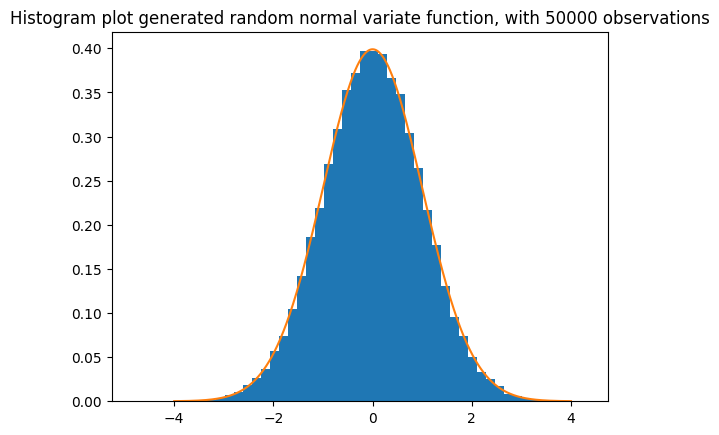

In [43]:
rng.seed(1)
print(rng.get_state()[2])
u1 = rng.normal(size=1)
print(rng.get_state()[2])
print(u1[0])

u2, state = python_random_normal(python_state_from_seed(1), size=50000)
print(u2[0])
print(state[0])

plt.hist(u2, bins=50, density=True)

x = np.linspace(-4,4,1000)
y = st.norm.pdf(x)
plt.plot(x,y)
plt.title('Histogram plot generated random normal variate function, with 50000 observations')
plt.show()

## R

In [48]:
def r_random_normal(state, mu=0, sigma=1, size=1):
    output = []
    def qnorm(p, mu, sigma, lower_tail, log_p):
        def R_D_Cval(p, lower_tail):
            if lower_tail:
                return 0.5-p+0.5
            else:
                return p
        def R_D_qIv(p, log_p):
            if log_p:
                return np.exp(p)
            else:
                return p
        def R_D_Lval(p, lower_tail):
            if lower_tail:
                return p
            else:
                return 0.5-p+0.5
        def R_DT_qIv(p, lower_tail, log_p):
            return R_D_Lval(R_D_qIv(p, log_p), lower_tail)
        p_ = R_DT_qIv(p, lower_tail, log_p)
        q = p_-0.5
        if abs(q)<=0.425:
            r=0.180625 - q**2
            val = q * (((((((r * 2509.0809287301226727 + 33430.575583588128105) * r + 67265.770927008700853) * r + 45921.953931549871457) * r + 13731.693765509461125) * r + 1971.5909503065514427) * r + 133.14166789178437745) * r + 3.387132872796366608) / (((((((r * 5226.495278852854561 + 28729.085735721942674) * r + 39307.89580009271061) * r + 21213.794301586595867) * r + 5394.1960214247511077) * r + 687.1870074920579083) * r + 42.313330701600911252) * r + 1.)
        else:
            if log_p and ((lower_tail and q <= 0) or (not(lower_tail) and q > 0)):
                r=p
            else:
                if q>0:
                    r=np.log(R_D_Cval(R_D_qIv(p,log_p), lower_tail))
                else:
                    r=np.log(p_)
            r=np.sqrt(-r)
            if r<=5:
                r+=(-1.6)
                val = (((((((r * 7.7454501427834140764e-4 + .0227238449892691845833) * r + .24178072517745061177) * r + 1.27045825245236838258) * r + 3.64784832476320460504) * r + 5.7694972214606914055) * r + 4.6303378461565452959) * r + 1.42343711074968357734) / (((((((r * 1.05075007164441684324e-9 + 5.475938084995344946e-4) * r + .0151986665636164571966) * r + .14810397642748007459) * r + .68976733498510000455) * r + 1.6763848301838038494) * r + 2.05319162663775882187) * r + 1.)
            elif r>=816:
                print('4')
                val = r * 1.41421356237309504880
            else:
                r+= (-5)
                val = (((((((r * 2.01033439929228813265e-7 + 2.71155556874348757815e-5) * r + .0012426609473880784386) * r + .026532189526576123093) * r + .29656057182850489123) * r + 1.7848265399172913358) * r + 5.4637849111641143699) * r + 6.6579046435011037772) / (((((((r * 2.04426310338993978564e-15 + 1.4215117583164458887e-7)* r + 1.8463183175100546818e-5) * r + 7.868691311456132591e-4) * r + .0148753612908506148525) * r + .13692988092273580531) * r + .59983220655588793769) * r + 1.)
            if q<0:
                val = -val
        return mu + sigma * val
    def r_random_normal_variate(state):
        big = 134217728
        u1, state = r_random_uniform(state)
        u2, state = r_random_uniform(state)
        u = int(big*u1[0]) + u2[0]
        return mu+sigma*qnorm(u/big, mu, sigma, True, False), state
    for n in range(size):
        n1, state = r_random_normal_variate(state)
        output.append(n1)
    return output, state

In [50]:
robjects.r('''
set.seed(1)
print(rnorm(5))
''')

r_random_normal(r_state_from_seed(1), size=5)[0]

[1] -0.6264538  0.1836433 -0.8356286  1.5952808  0.3295078


[-0.6264538107423324,
 0.18364332422208224,
 -0.8356286124100472,
 1.5952808021377916,
 0.3295077718153605]

## C++

In [51]:
def cplusplus_erf_inv(p):
    q=1-p
    def evaluate_polynomial(poly, z):
        count = len(poly)
        sum = poly[count-1]
        for i in range(count-1):
            idx = count-2-i
            sum*=z
            sum+=poly[idx]
        return sum
    result=0
    if p<=0.5:
        Y = 0.0891314744949340820313
        P = [
            -0.000508781949658280665617,
            -0.00836874819741736770379,
            0.0334806625409744615033,
            -0.0126926147662974029034,
            -0.0365637971411762664006,
            0.0219878681111168899165,
            0.00822687874676915743155,
            -0.00538772965071242932965
            ]
        Q = [         
            1,
            -0.970005043303290640362,
            -1.56574558234175846809,
            1.56221558398423026363,
            0.662328840472002992063,
            -0.71228902341542847553,
            -0.0527396382340099713954,
            0.0795283687341571680018,
            -0.00233393759374190016776,
            0.000886216390456424707504
            ]
        g = p*(p+10)
        r = evaluate_polynomial(P, p)/evaluate_polynomial(Q, p)
        result = g*Y+g*r
    elif q>=0.25:
        Y = 2.249481201171875
        P = [
            -0.202433508355938759655,
            0.105264680699391713268,
            8.37050328343119927838,
            17.6447298408374015486,
            -18.8510648058714251895,
            -44.6382324441786960818,
            17.445385985570866523,
            21.1294655448340526258,
            -3.67192254707729348546
            ]
        Q = [
            1,
            6.24264124854247537712,
            3.9713437953343869095,
            -28.6608180499800029974,
            -20.1432634680485188801,
            48.5609213108739935468,
            10.8268667355460159008,
            -22.6436933413139721736,
            1.72114765761200282724
            ]
        g = np.sqrt(-2*np.log(q))
        xs = q - 0.25
        r = evaluate_polynomial(P, xs)/evaluate_polynomial(Q, xs)
        result = g / (Y+r)
    else:
        x = np.sqrt(-np.log(q))
        if x<3:
            Y = 0.807220458984375
            P = [
            -0.131102781679951906451,
            -0.163794047193317060787,
            0.117030156341995252019,
            0.387079738972604337464,
            0.337785538912035898924,
            0.142869534408157156766,
            0.0290157910005329060432,
            0.00214558995388805277169,
            -0.679465575181126350155e-6,
            0.285225331782217055858e-7,
            -0.681149956853776992068e-9
            ]
            Q = [
                1,
                3.46625407242567245975,
                5.38168345707006855425,
                4.77846592945843778382,
                2.59301921623620271374,
                0.848854343457902036425,
                0.152264338295331783612,
                0.01105924229346489121
                ]
            xs = x - 1.125
            R = evaluate_polynomial(P, xs)/evaluate_polynomial(Q, xs)
            result = Y*x+R*x
        elif x<6:
            Y = 0.93995571136474609375
            P = [
                -0.0350353787183177984712,
                -0.00222426529213447927281,
                0.0185573306514231072324,
                0.00950804701325919603619,
                0.00187123492819559223345,
                0.000157544617424960554631,
                0.460469890584317994083e-5,
                -0.230404776911882601748e-9,
                0.266339227425782031962e-11
                ]
            Q = [            
                1,
                1.3653349817554063097,
                0.762059164553623404043,
                0.220091105764131249824,
                0.0341589143670947727934,
                0.00263861676657015992959,
                0.764675292302794483503e-4
                ]
            xs = x-3
            R = evaluate_polynomial(P, xs)/ evaluate_polynomial(Q, xs)
            result = Y*x+R*x
        elif x<18:
            Y = 0.98362827301025390625
            P = [
                -0.0167431005076633737133,
                -0.00112951438745580278863,
                0.00105628862152492910091,
                0.000209386317487588078668,
                0.149624783758342370182e-4,
                0.449696789927706453732e-6,
                0.462596163522878599135e-8,
                -0.281128735628831791805e-13,
                0.99055709973310326855e-16
                ]
            Q = [
                1,
                0.591429344886417493481,
                0.138151865749083321638,
                0.0160746087093676504695,
                0.000964011807005165528527,
                0.275335474764726041141e-4,
                0.282243172016108031869e-6
                ]
            xs = x-6
            R = evaluate_polynomial(P, xs)/ evaluate_polynomial(Q, xs)
            result = Y*x+R*x
        elif x<44:
            Y = 0.99714565277099609375
            P = [
                -0.0024978212791898131227,
                -0.779190719229053954292e-5,
                0.254723037413027451751e-4,
                0.162397777342510920873e-5,
                0.396341011304801168516e-7,
                0.411632831190944208473e-9,
                0.145596286718675035587e-11,
                -0.116765012397184275695e-17
                ]
            Q = [
                1,
                0.207123112214422517181,
                0.0169410838120975906478,
                0.000690538265622684595676,
                0.145007359818232637924e-4,
                0.144437756628144157666e-6,
                0.509761276599778486139e-9
                ]
            xs = x-18
            R = evaluate_polynomial(P, xs)/ evaluate_polynomial(Q, xs)
            result = Y*x+R*x
        else:
            Y = 0.99941349029541015625
            P = [
                -0.000539042911019078575891,
                -0.28398759004727721098e-6,
                0.899465114892291446442e-6,
                0.229345859265920864296e-7,
                0.225561444863500149219e-9,
                0.947846627503022684216e-12,
                0.135880130108924861008e-14,
                -0.348890393399948882918e-21
                ]
            Q = [
                1,
                0.0845746234001899436914,
                0.00282092984726264681981,
                0.468292921940894236786e-4,
                0.399968812193862100054e-6,
                0.161809290887904476097e-8,
                0.231558608310259605225e-11
                ]
            xs = x-44
            R = evaluate_polynomial(P, xs)/ evaluate_polynomial(Q, xs)
            result = Y*x+R*x
    return result

def cplusplus_random_normal(state, mu=0, sigma=1, size=1):
    output = []
    for n in range(size):
        u1, state = cplusplus_generate_canonical(state)
        output.append(mu+sigma*np.sqrt(2)*cplusplus_erf_inv(2*u1[0]-1))
    return output, state


def cplusplus_boost_normal(state, mu=0, sigma=1, size=1):
    table_x = [
        3.7130862467403632609, 3.4426198558966521214, 3.2230849845786185446, 3.0832288582142137009,
        2.9786962526450169606, 2.8943440070186706210, 2.8231253505459664379, 2.7611693723841538514,
        2.7061135731187223371, 2.6564064112581924999, 2.6109722484286132035, 2.5690336259216391328,
        2.5300096723854666170, 2.4934545220919507609, 2.4590181774083500943, 2.4264206455302115930,
        2.3954342780074673425, 2.3658713701139875435, 2.3375752413355307354, 2.3104136836950021558,
        2.2842740596736568056, 2.2590595738653295251, 2.2346863955870569803, 2.2110814088747278106,
        2.1881804320720206093, 2.1659267937448407377, 2.1442701823562613518, 2.1231657086697899595,
        2.1025731351849988838, 2.0824562379877246441, 2.0627822745039633575, 2.0435215366506694976,
        2.0246469733729338782, 2.0061338699589668403, 1.9879595741230607243, 1.9701032608497132242,
        1.9525457295488889058, 1.9352692282919002011, 1.9182573008597320303, 1.9014946531003176140,
        1.8849670357028692380, 1.8686611409895420085, 1.8525645117230870617, 1.8366654602533840447,
        1.8209529965910050740, 1.8054167642140487420, 1.7900469825946189862, 1.7748343955807692457,
        1.7597702248942318749, 1.7448461281083765085, 1.7300541605582435350, 1.7153867407081165482,
        1.7008366185643009437, 1.6863968467734863258, 1.6720607540918522072, 1.6578219209482075462,
        1.6436741568569826489, 1.6296114794646783962, 1.6156280950371329644, 1.6017183802152770587,
        1.5878768648844007019, 1.5740982160167497219, 1.5603772223598406870, 1.5467087798535034608,
        1.5330878776675560787, 1.5195095847593707806, 1.5059690368565502602, 1.4924614237746154081,
        1.4789819769830978546, 1.4655259573357946276, 1.4520886428822164926, 1.4386653166774613138,
        1.4252512545068615734, 1.4118417124397602509, 1.3984319141236063517, 1.3850170377251486449,
        1.3715922024197322698, 1.3581524543224228739, 1.3446927517457130432, 1.3312079496576765017,
        1.3176927832013429910, 1.3041418501204215390, 1.2905495919178731508, 1.2769102735516997175,
        1.2632179614460282310, 1.2494664995643337480, 1.2356494832544811749, 1.2217602305309625678,
        1.2077917504067576028, 1.1937367078237721994, 1.1795873846544607035, 1.1653356361550469083,
        1.1509728421389760651, 1.1364898520030755352, 1.1218769225722540661, 1.1071236475235353980,
        1.0922188768965537614, 1.0771506248819376573, 1.0619059636836193998, 1.0464709007525802629,
        1.0308302360564555907, 1.0149673952392994716, 0.99886423348064351303, 0.98250080350276038481,
        0.96585507938813059489, 0.94890262549791195381, 0.93161619660135381056, 0.91396525100880177644,
        0.89591535256623852894, 0.87742742909771569142, 0.85845684317805086354, 0.83895221428120745572,
        0.81885390668331772331, 0.79809206062627480454, 0.77658398787614838598, 0.75423066443451007146,
        0.73091191062188128150, 0.70647961131360803456, 0.68074791864590421664, 0.65347863871504238702,
        0.62435859730908822111, 0.59296294244197797913, 0.55869217837551797140, 0.52065603872514491759,
        0.47743783725378787681, 0.42654798630330512490, 0.36287143102841830424, 0.27232086470466385065,
        0
    ]

    table_y = [
        0, 0.0026696290839025035092, 0.0055489952208164705392, 0.0086244844129304709682,
        0.011839478657982313715, 0.015167298010672042468, 0.018592102737165812650, 0.022103304616111592615,
        0.025693291936149616572, 0.029356317440253829618, 0.033087886146505155566, 0.036884388786968774128,
        0.040742868074790604632, 0.044660862200872429800, 0.048636295860284051878, 0.052667401903503169793,
        0.056752663481538584188, 0.060890770348566375972, 0.065080585213631873753, 0.069321117394180252601,
        0.073611501884754893389, 0.077950982514654714188, 0.082338898242957408243, 0.086774671895542968998,
        0.091257800827634710201, 0.09578784912257815216, 0.10036444102954554013, 0.10498725541035453978,
        0.10965602101581776100, 0.11437051244988827452, 0.11913054670871858767, 0.12393598020398174246,
        0.12878670619710396109, 0.13368265258464764118, 0.13862377998585103702, 0.14361008009193299469,
        0.14864157424369696566, 0.15371831220958657066, 0.15884037114093507813, 0.16400785468492774791,
        0.16922089223892475176, 0.17447963833240232295, 0.17978427212496211424, 0.18513499701071343216,
        0.19053204032091372112, 0.19597565311811041399, 0.20146611007620324118, 0.20700370944187380064,
        0.21258877307373610060, 0.21822164655637059599, 0.22390269938713388747, 0.22963232523430270355,
        0.23541094226572765600, 0.24123899354775131610, 0.24711694751469673582, 0.25304529850976585934,
        0.25902456739871074263, 0.26505530225816194029, 0.27113807914102527343, 0.27727350292189771153,
        0.28346220822601251779, 0.28970486044581049771, 0.29600215684985583659, 0.30235482778947976274,
        0.30876363800925192282, 0.31522938806815752222, 0.32175291587920862031, 0.32833509837615239609,
        0.33497685331697116147, 0.34167914123501368412, 0.34844296754987246935, 0.35526938485154714435,
        0.36215949537303321162, 0.36911445366827513952, 0.37613546951445442947, 0.38322381105988364587,
        0.39038080824138948916, 0.39760785649804255208, 0.40490642081148835099, 0.41227804010702462062,
        0.41972433205403823467, 0.42724699830956239880, 0.43484783025466189638, 0.44252871528024661483,
        0.45029164368692696086, 0.45813871627287196483, 0.46607215269457097924, 0.47409430069824960453,
        0.48220764633483869062, 0.49041482528932163741, 0.49871863547658432422, 0.50712205108130458951,
        0.51562823824987205196, 0.52424057267899279809, 0.53296265938998758838, 0.54179835503172412311,
        0.55075179312105527738, 0.55982741271069481791, 0.56902999107472161225, 0.57836468112670231279,
        0.58783705444182052571, 0.59745315095181228217, 0.60721953663260488551, 0.61714337082656248870,
        0.62723248525781456578, 0.63749547734314487428, 0.64794182111855080873, 0.65858200005865368016,
        0.66942766735770616891, 0.68049184100641433355, 0.69178914344603585279, 0.70333609902581741633,
        0.71515150742047704368, 0.72725691835450587793, 0.73967724368333814856, 0.75244155918570380145,
        0.76558417390923599480, 0.77914608594170316563, 0.79317701178385921053, 0.80773829469612111340,
        0.82290721139526200050, 0.83878360531064722379, 0.85550060788506428418, 0.87324304892685358879,
        0.89228165080230272301, 0.91304364799203805999, 0.93628268170837107547, 0.96359969315576759960,
        1
    ]
    output=[]
    def generate_tail():
        tail_start = table_x[1]
        while True:
            x, state = cplusplus_boost_exponential(state)
            x = x/tail_start
            y, state = cplusplus_boost_exponential(state)
            if 2*y>x**2:
                return x+tail_start, state
    def variate(state):
        while True:
            j, i, state = cplusplus_boost_generate_int_float_pair(state, 8)
            sign = (i&1)*2-1
            i = i>>1
            x = j*table_x[i]
            if x<table_x[i+1]:
                return x*sign, state
            if i==0:
                return generate_tail()*sign, state
            y_01, state = cplusplus_boost_uniform_01(state)
            y_01=y_01[0]
            y = table_y[i]+y_01*(table_y[i+1]-table_y[i])
            if table_x[i]>=1:
                y_above_ubound = (table_x[i]-table_x[i+1])*y_01-(table_x[i]-x)
                y_above_ubound = y - (table_y[i]+(table_x[i]-x)*table_y[i]*table_x[i])
            else:
                y_above_lbound = (table_x[i]-table_x[i+1])*y_01-(table_x[i]-x)
                y_above_ubound = y - (table_y[i]+(table_x[i]-x)*table_y[i]*table_x[i])
            if (y_above_ubound<0 and y_above_lbound<0) or (y<np.exp(-x**2/2)):
                return x*sign, state
    for n in range(size):
        n1, state = variate(state)
        output.append(n1)
    return output, state

In [53]:
print(cplusplus_boost_normal(cplusplus_state_from_seed(1), size=5)[0])

[2.2849294606911874, -0.6686271260558455, 0.006806818552631442, 0.26210960720511955, -0.8068316573936928]


# Randomly Sampling and Shuffling 1-D Lists

## Python

In [54]:
def python_random_interval(max, state):
    if max==0:
        return 0
    mask = max
    mask|=mask>>1
    mask|=mask>>2
    mask|=mask>>4
    mask|=mask>>8
    mask|=mask>>16
    mask|=mask>>32
    if max<=0xffffffff:
        integer, state = mt19937_next(state)
        value = integer&mask
        while value>max:
            integer, state = mt19937_next(state)
            value = integer&mask
    else:
        integer, state = python_next_64(state)
        value = integer&mask
        while value>max:
            integer, state = python_next_64(state)
            value = integer&mask
    return value, state    

def python_shuffle(x, state):
    n = len(x)
    for i in reversed(range(1,n)):
        j, state = python_random_interval(i, state)
        buf = x[j]
        x[j] = x[i]
        x[i] = buf
    return x, state

In [55]:
state = python_state_from_seed(1)
x = [0,1,2,3,4,5,6,7,8]
print(python_shuffle(x, state)[0])
rng.seed(1)
x = [0,1,2,3,4,5,6,7,8]
rng.shuffle(x)
print(x)

[8, 2, 6, 7, 1, 0, 4, 3, 5]
[8, 2, 6, 7, 1, 0, 4, 3, 5]


In [56]:
def python_random_choice(n, size, replace, state, p=None):
    if replace:
        if p is not None:
            cdf = p.cumsum()
            cdf /= cdf[-1]
            uniform_samples, state = python_random_uniform(state, size=size)
            idx = cdf.searchsorted(uniform_samples, side='right')
            idx = np.array(idx, copy=False).astype(int, casting='unsafe')
        else:
            idx = np.empty(size, dtype=int)
            for i in range(size):
                idx[i], state = python_random_interval(n-1, state)
    else:
        if p is not None:
            n_uniq=0
            p = p.copy()
            found = np.zeros(size, dtype=int)
            flat_found = found.ravel()
            while n_uniq<size:
                x, state = python_random_uniform(state=state,size=size-n_uniq)
                if n_uniq>0:
                    p[flat_found[0:n_uniq]]=0
                cdf = np.cumsum(p)
                cdf/=cdf[-1]
                new = cdf.searchsorted(x, side='right')
                _, unique_indices = np.unique(new, return_index=True)
                unique_indices.sort()
                new = new.take(unique_indices)
                flat_found[n_uniq:n_uniq + new.size] = new
                n_uniq += new.size
            idx = found  
        else:
            shuffle_list, state = python_shuffle(np.arange(n, dtype=int), state)
            idx = shuffle_list[0:size]
    return idx, state


In [57]:
print('Sampling our list with replacement and not specifying the discrete distribution to sample from.')
print('The output from our function:')
state = python_state_from_seed(1)
sample_list, state = python_random_choice(n=9, size=6, replace=True, state=state)
print(sample_list)
print("The output from NumPy's built in choices function:")
x = [0,1,2,3,4,5,6,7,8]
rng.seed(1)
print(rng.choice(x, size=6, replace=True))
print('\nSampling our list with replacement and by specifying the discrete distribution to sample from.')
print('The output from our function:')
state = python_state_from_seed(1)
sample_list, state = python_random_choice(n=9, size=6, replace=True, state=state, p=np.ones(9)/9)
print(sample_list)
print("The output from NumPy's built in choices function:")
x = [0,1,2,3,4,5,6,7,8]
rng.seed(1)
print(rng.choice(x, size=6, replace=True, p=np.ones(9)/9))
print('\nSampling our list without replacement and not specifying the discrete distribution to sample from.')
print('The output from our function:')
state = python_state_from_seed(1)
sample_list, state = python_random_choice(n=9, size=6, replace=False, state=state)
print(sample_list)
print("The output from NumPy's built in choices function:")
x = [0,1,2,3,4,5,6,7,8]
rng.seed(1)
print(rng.choice(x, size=6, replace=False))
print('\nSampling our list without replacement and by specifying the discrete distribution to sample from.')
print('The output from our function:')
state = python_state_from_seed(1)
sample_list, state = python_random_choice(n=9, size=6, replace=False, state=state, p=np.ones(9)/9)
print(sample_list)
print("The output from NumPy's built in choices function:")
x = [0,1,2,3,4,5,6,7,8]
rng.seed(1)
print(rng.choice(x, size=6, replace=False, p=np.ones(9)/9))

Sampling our list with replacement and not specifying the discrete distribution to sample from.
The output from our function:
[5 8 5 0 0 1]
The output from NumPy's built in choices function:
[5 8 5 0 0 1]

Sampling our list with replacement and by specifying the discrete distribution to sample from.
The output from our function:
[3 6 0 2 1 0]
The output from NumPy's built in choices function:
[3 6 0 2 1 0]

Sampling our list without replacement and not specifying the discrete distribution to sample from.
The output from our function:
[8 2 6 7 1 0]
The output from NumPy's built in choices function:
[8 2 6 7 1 0]

Sampling our list without replacement and by specifying the discrete distribution to sample from.
The output from our function:
[3 6 0 2 1 4]
The output from NumPy's built in choices function:
[3 6 0 2 1 4]


## R

In [58]:
def r_rbits(bits, state):
    v=0
    n=0
    while n<=bits:
        u1, state = r_random_uniform(state)
        v1 = int(np.floor(u1[0]*65536))
        v = 65536*v+v1
        n+=16
    return v&((1 << bits)-1), state

def r_R_unif_index(dn, state):
    if dn<=0:
        return 0, state
    bits = int(np.ceil(np.log2(dn)))
    dv, state = r_rbits(bits, state)
    while dn<=dv:
        dv, state = r_rbits(bits, state)
    return dv, state

def r_random_sample_replace_prob(n, p, size, state):
    perm = np.empty(n)
    ans = np.empty(size, dtype=int)
    nm1 = n-1
    for i in range(n):
        perm[i]=i
    for i in range(1,n):
        p[i]+=p[i-1]
    for i in range(size):
        rU, state = r_random_uniform(state)
        for j in range(nm1):
            if rU[0]<=p[j]:
                break
        if rU[0]>p[j]:
            j=nm1
        ans[i]=(perm[j]+1)%n
    return ans, state

def r_random_sample_replace_noprob(n, size, state):
    y = np.empty(size, dtype=int)
    for i in range(size):
        j, state = r_R_unif_index(n, state)
        y[i]=j
    return y, state

def r_random_sample_noreplace_prob(n, size, p, state):
    perm = np.empty(n)
    ans = np.empty(size, dtype=int)
    for i in range(n):
        perm[i]=i
    totalmass=1
    n1=n-1
    for i in range(size):
        u, state = r_random_uniform(state)
        rT= totalmass * u[0]
        mass=0
        for j in range(n1):
            mass+=p[j]
            if rT<=mass:
                break
        if rT>mass:
            j=n1
        ans[i]=(perm[j]+1)%n
        totalmass-=p[j]
        for k in range(j,n1):
            p[k]=p[k+1]
            perm[k]=perm[k+1]
        n1-=1
    return ans, state

def r_random_sample_noreplace_noprob(n, size, state):
    x = np.empty(n)
    y = np.empty(size, dtype=int)
    for i in range(n):
        x[i] = i
    N=n
    for k in range(size):
        j, state = r_R_unif_index(N, state)
        y[k]=x[j]
        N-=1
        x[j] = x[N]
    return y, state

In [59]:
print('Sampling our list with replacement and by specifying the discrete distribution to sample from.')
print('The output from our function:')
state = (r_state_from_seed(1))
sample_list, state = r_random_sample_replace_prob(n=9, p=np.ones(9)/9, size=6, state=state)
print(sample_list)
print("The output from R's built in sample function:")
robjects.r('''
set.seed(1)
x<-c(0,1,2,3,4,5,6,7,8)
print(sample(x, replace=TRUE, prob=c(1,1,1,1,1,1,1,1,1), size=6))
''')
print('\nSampling our list with replacement and not specifying the discrete distribution to sample from.')
print('The output from our function:')
state = r_state_from_seed(1)
sample_list, state = r_random_sample_replace_noprob(n=9, size=6, state=state)
print(sample_list)
print("The output from R's built in sample function:")
robjects.r('''
set.seed(1)
x<-c(0,1,2,3,4,5,6,7,8)
print(sample(x, replace=TRUE, size=6))
''')
print('\nSampling our list without replacement and by specifying the discrete distribution to sample from.')
print('The output from our function:')
state = r_state_from_seed(1)
sample_list, state = r_random_sample_noreplace_prob(n=9, size=6, p=np.ones(9)/9, state=state)
print(sample_list)
print("The output from R's built in sample function:")
robjects.r('''
set.seed(1)
x<-c(0,1,2,3,4,5,6,7,8)
print(sample(x, replace=FALSE, prob=c(1,1,1,1,1,1,1,1,1), size=6))
''')
print('\nSampling our list without replacement and not specifying the discrete distribution to sample from.')
print('The output from our function:')
state = (r_state_from_seed(1))
sample_list, state = r_random_sample_noreplace_noprob(n=9, size=6, state=state)
print(sample_list)
print("The output from R's built in sample function:")
robjects.r('''
set.seed(1)
x<-c(0,1,2,3,4,5,6,7,8)
print(sample(x, replace=FALSE, size=6))
''')

Sampling our list with replacement and by specifying the discrete distribution to sample from.
The output from our function:
[3 4 6 0 2 0]
The output from R's built in sample function:
[1] 3 4 6 0 2 0

Sampling our list with replacement and not specifying the discrete distribution to sample from.
The output from our function:
[8 3 6 0 1 6]
The output from R's built in sample function:
[1] 8 3 6 0 1 6

Sampling our list without replacement and by specifying the discrete distribution to sample from.
The output from our function:
[3 4 7 0 2 8]
The output from R's built in sample function:
[1] 3 4 7 0 2 8

Sampling our list without replacement and not specifying the discrete distribution to sample from.
The output from our function:
[8 3 6 0 1 5]
The output from R's built in sample function:
[1] 8 3 6 0 1 5


8.000000,3.000000,6.000000,0.000000,1.000000,5.000000
